In [1]:
# 授權绑定Google Drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 134985 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.14-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.14-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.14-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redir

In [2]:
# 取得雲端資料夾
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# 列出資料夾底下的檔案列表
import os
os.chdir("/content/drive/My Drive/04 中興資管所/5 上課資料/電腦視覺與人機互動/final_project/final_project")
!ls

 glove.6B
 glove.6B.zip
 model_plot4a.png
 model_plot4b.png
'Multi-label Text Classification with Keras.ipynb'
'Multi-label Text Classification with Keras_Multiple Output Layers'
 Multi_label_Text_Classification_with_Keras_Multiple_Output_Layers.ipynb
 Multi_label_Text_Classification_with_Keras_Multiple_Output_Layers.pdf
 Multi_label_Text_Classification_with_Keras_Multiple_Output_Layers.py
'Multi-label Text Classification with Keras_Single Output Layers'
 Multi_label_Text_Classification_with_Keras_Single_Output_Layers.ipynb
 Multi_label_Text_Classification_with_Keras_Single_Output_Layers.pdf
 Multi_label_Text_Classification_with_Keras_Single_Output_Layers.py
 toxic-comment-classification
 toxic-comment-classification.zip
 toxic_comments.csv


In [4]:
# 匯入模組
import re
import pydot
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from google.colab import drive, files

Using TensorFlow backend.


In [5]:
# 將csv讀入colab的授權前置作業
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
drive

In [6]:
# 取得csv的共用連結'toxic_comments.csv'
link = 'https://drive.google.com/open?id=1w-NPyCW38I7CDVk4eDR6r6Cu6IL9UyfU' 
# The shareable link
fluff, id = link.split('=')
print('id =',id)

id = 1w-NPyCW38I7CDVk4eDR6r6Cu6IL9UyfU


In [7]:
# csv匯入dataframe
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('toxic_comments.csv')  
toxic_comments = pd.read_csv('toxic_comments.csv')
# 印出前5列
toxic_comments.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
# dataframe大小
toxic_comments.shape

(159571, 8)

In [9]:
# 刪除所有列包含空值或空字符串
filter = toxic_comments["comment_text"] != ""
toxic_comments = toxic_comments[filter]
toxic_comments = toxic_comments.dropna()
print('toxic_comments_filter Shape = ',toxic_comments.shape)

toxic_comments_filter Shape =  (159571, 8)


In [10]:
# 找其中一筆資料測試comment的詞語對應到的類別
print(toxic_comments["comment_text"][168])
print("Toxic:" + str(toxic_comments["toxic"][168]))
print("Severe_toxic:" + str(toxic_comments["severe_toxic"][168]))
print("Obscene:" + str(toxic_comments["obscene"][168]))
print("Threat:" + str(toxic_comments["threat"][168]))
print("Insult:" + str(toxic_comments["insult"][168]))
print("Identity_hate:" + str(toxic_comments["identity_hate"][168]))

You should be fired, you're a moronic wimp who is too lazy to do research. It makes me sick that people like you exist in this world.
Toxic:1
Severe_toxic:0
Obscene:0
Threat:0
Insult:1
Identity_hate:0


In [11]:
# 繪製每個標籤的評論數
toxic_comments_labels = toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
toxic_comments_labels.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


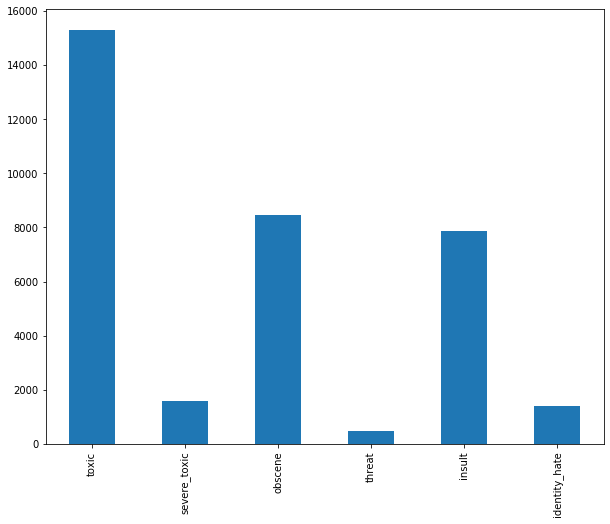

In [12]:
# 畫成長條圖
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

toxic_comments_labels.sum(axis=0).plot.bar()

**Multi-lable Text Classification Model with Multiple Output Layers**

In [0]:
# 文本分類模型的第一步是創建一個函式負責清理文本
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [0]:
# 清理完的文本儲存在X
X = []
sentences = list(toxic_comments["comment_text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]

In [0]:
# 分割訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [0]:
# y變量包含6個標籤的組合輸出
# First output
y1_train = y_train[["toxic"]].values
y1_test =  y_test[["toxic"]].values

# Second output
y2_train = y_train[["severe_toxic"]].values
y2_test =  y_test[["severe_toxic"]].values

# Third output
y3_train = y_train[["obscene"]].values
y3_test =  y_test[["obscene"]].values

# Fourth output
y4_train = y_train[["threat"]].values
y4_test =  y_test[["threat"]].values

# Fifth output
y5_train = y_train[["insult"]].values
y5_test =  y_test[["insult"]].values

# Sixth output
y6_train = y_train[["identity_hate"]].values
y6_test =  y_test[["identity_hate"]].values

In [17]:
# 將文本輸入轉換為嵌入向量
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
print('vocab_size = ',vocab_size)

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

vocab_size =  148243


In [0]:
# 使用GloVe詞嵌入
embeddings_dictionary = dict()
glove_file = open('/content/drive/My Drive/04 中興資管所/5 上課資料/電腦視覺與人機互動/final_project/final_project/glove.6B/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [19]:
# 建立LSTM模型
input_1 = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_1)
LSTM_Layer1 = LSTM(128)(embedding_layer)

output1 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output2 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output3 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output4 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output5 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output6 = Dense(1, activation='sigmoid')(LSTM_Layer1)

model = Model(inputs=input_1, outputs=[output1, output2, output3, output4, output5, output6])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])












Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 100)     14824300    input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 128)          117248      embedding_1[0][0]                
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1)            129         lstm_1[0][0]                     
____________________________________________________________________________________________

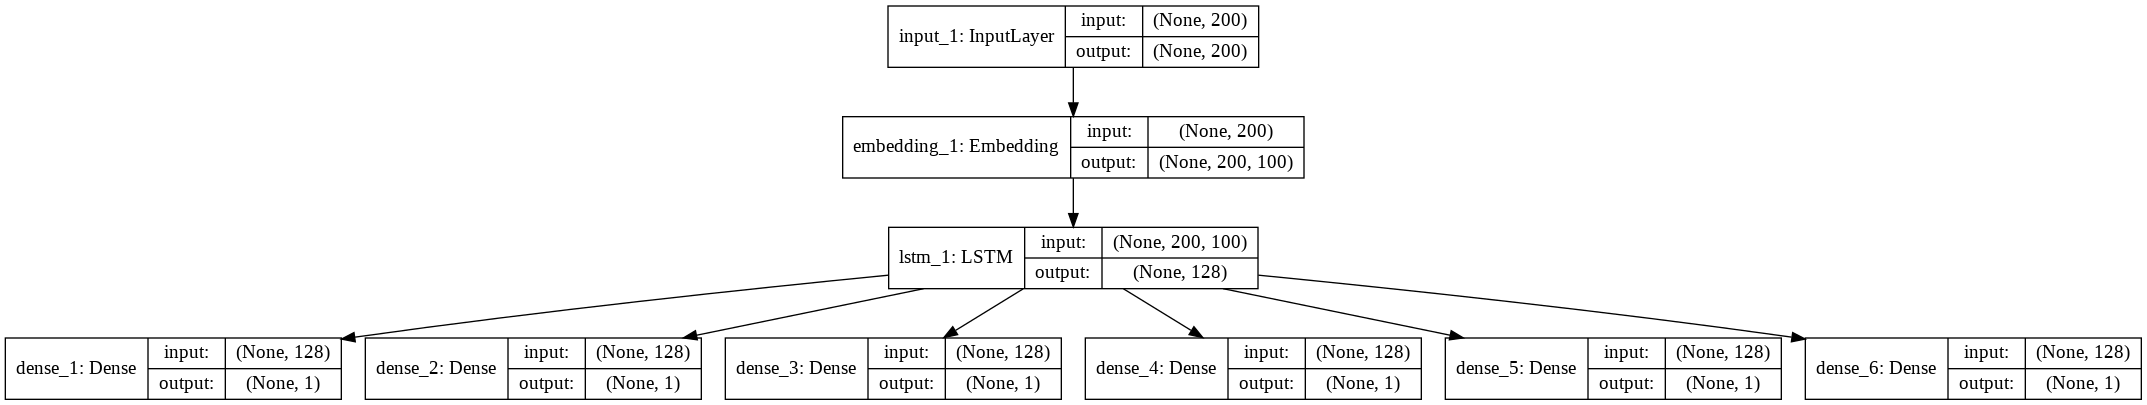

In [21]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4b.png', show_shapes=True, show_layer_names=True)

In [22]:
history = model.fit(x=X_train, y=[y1_train, y2_train, y3_train, y4_train, y5_train, y6_train], batch_size=8192, epochs=5, verbose=1, validation_split=0.2)



Train on 102124 samples, validate on 25532 samples
Epoch 1/5
102124/102124 [==============================] - 85s 835us/step - loss: 3.5806 - dense_1_loss: 0.6208 - dense_2_loss: 0.5916 - dense_3_loss: 0.5932 - dense_4_loss: 0.5811 - dense_5_loss: 0.6198 - dense_6_loss: 0.5742 - dense_1_acc: 0.8998 - dense_2_acc: 0.9835 - dense_3_acc: 0.9432 - dense_4_acc: 0.9928 - dense_5_acc: 0.9499 - dense_6_acc: 0.9909 - val_loss: 1.0263 - val_dense_1_loss: 0.3188 - val_dense_2_loss: 0.1234 - val_dense_3_loss: 0.2083 - val_dense_4_loss: 0.0643 - val_dense_5_loss: 0.2312 - val_dense_6_loss: 0.0803 - val_dense_1_acc: 0.9037 - val_dense_2_acc: 0.9900 - val_dense_3_acc: 0.9468 - val_dense_4_acc: 0.9966 - val_dense_5_acc: 0.9509 - val_dense_6_acc: 0.9901
Epoch 2/5
102124/102124 [==============================] - 79s 777us/step - loss: 0.9019 - dense_1_loss: 0.3175 - dense_2_loss: 0.0744 - dense_3_loss: 0.2183 - dense_4_loss: 0.0341 - dense_5_loss: 0.2025 - dense_6_loss: 0.0551 - dense_1_acc: 0.9043 - 

In [23]:
# 評估模型準確率
score = model.evaluate(x=X_test, y=[y1_test, y2_test, y3_test, y4_test, y5_test, y6_test], verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

31915/31915 [==============================] - 37s 1ms/step
Test Score: 0.8477085876330376
Test Accuracy: 0.31438121781647255


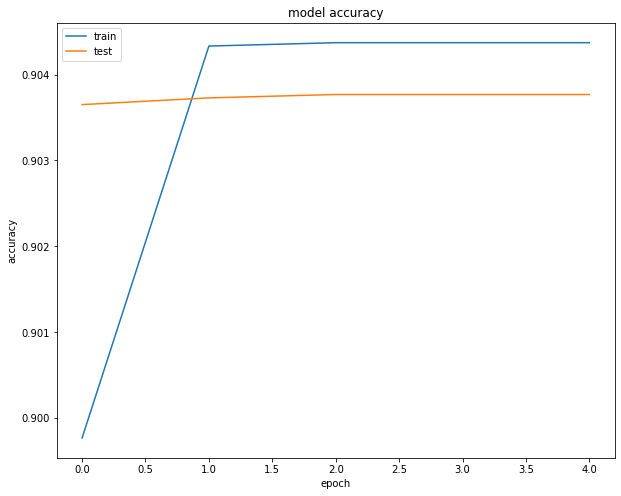

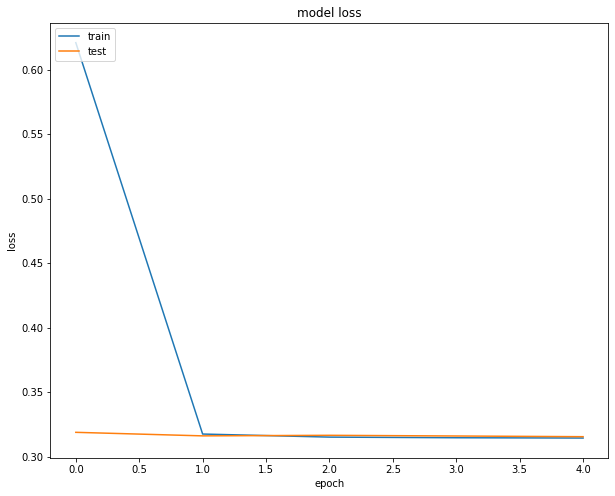

In [24]:
# 畫成圖
plt.plot(history.history['dense_1_acc'])
plt.plot(history.history['val_dense_1_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['dense_1_loss'])
plt.plot(history.history['val_dense_1_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()